# ANIMAL DETECTİON WİTH CNN

The Aygaz image processing bootcamp is being held in collaboration with Global AI and Aygaz.

## İntroduction

The aim of this project is to reinforce the fundamentals of CNN models. To achieve this, we will build a **CNN model** and use it to classify various animal species. For example, we will differentiate between two classes, such as "panda" and "dog," using a CNN. By doing so, we will understand the steps needed for CNN models to "simply" make the same distinctions we can make at a glance.

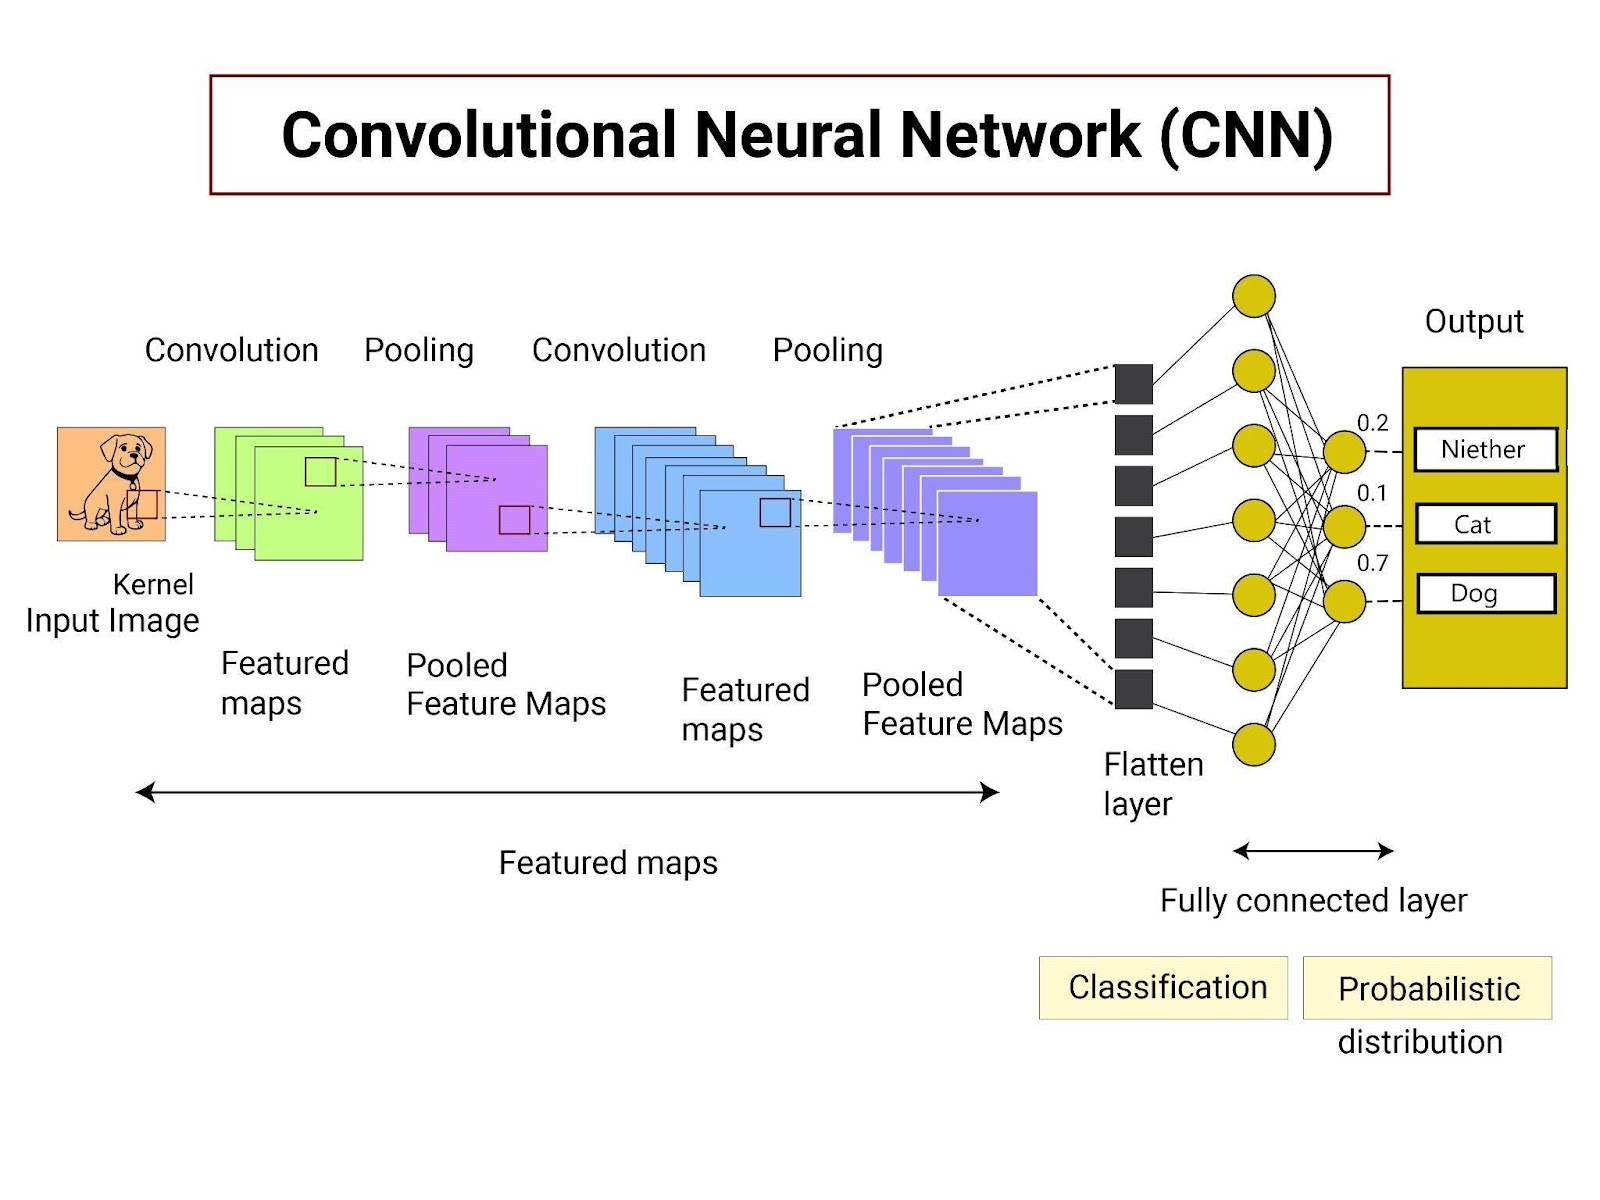
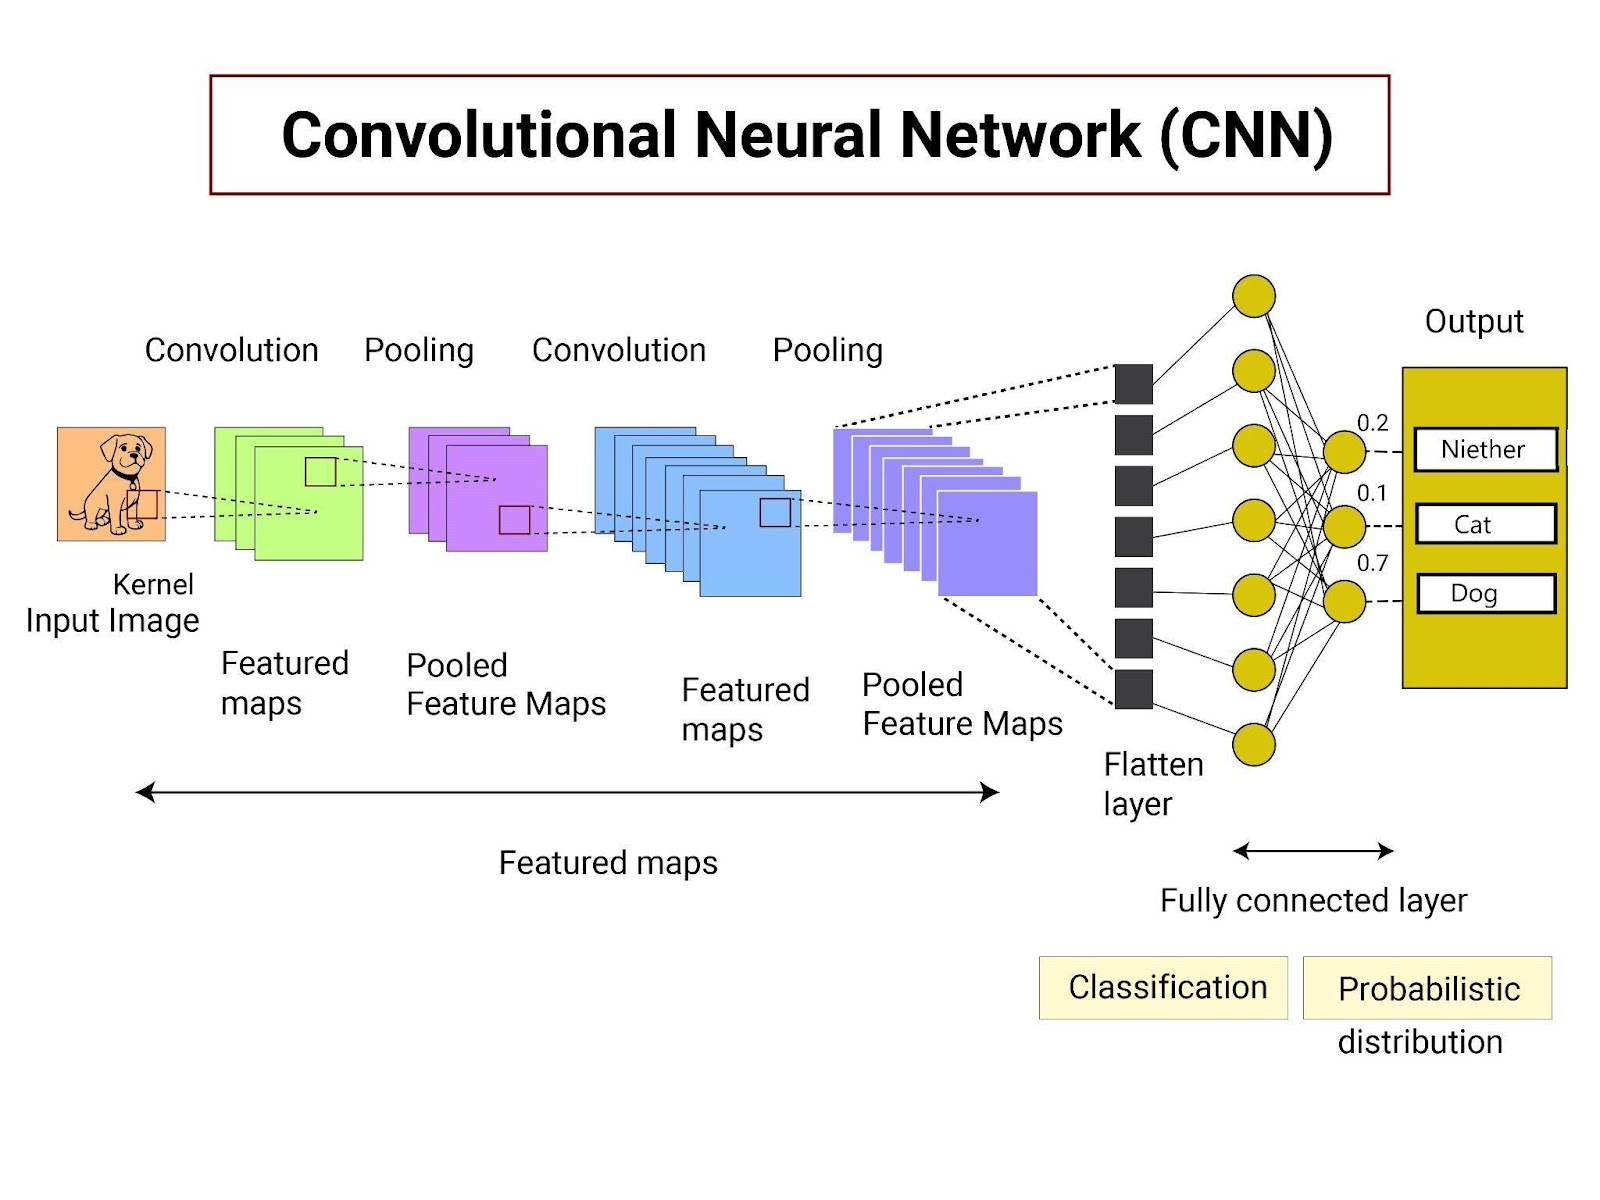

## Libraries

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.config.optimizer.set_experimental_options({"disable_xla": True})
import warnings
warnings.filterwarnings("ignore")

## Preparing The Dataset 

The classification will be performed for only 10 classes: **collie, dolphin, elephant, fox, moose, rabbit, sheep, squirrel, giant panda, and polar bear**. To ensure balanced data, use only the first **650 images** from each class. (You can write a code snippet to keep the first 650 images for each class and delete the rest.) You must resize all images to the same dimensions and normalize them. Adjust the image size according to the input layer of your model. If the image size is too large, the number of model parameters and the training time will increase.

In [3]:
path = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"  
target = "/kaggle/working/FilteredImages"

classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650

# Create the target directory
os.makedirs(target, exist_ok=True)

# Loop through each class and copy the images
for class_name in classes:
    class_path = os.path.join(path, class_name)
    target_path = os.path.join(target, class_name)
    
    if not os.path.exists(class_path):
        print(f"Source class path {class_path} does not exist. Skipping...")
        continue
    
    # Create a subdirectory for each class in the target directory
    os.makedirs(target_path, exist_ok=True)
    
    print(f"Processing class: {class_name}")
    image_count = 0
    available_files = os.listdir(class_path)
    
    # Adjust images_per_class to the number of available images
    total_images = len(available_files)
    images_to_copy = min(images_per_class, total_images)
    print(f"Found {total_images} images. Attempting to copy {images_to_copy} images.")
    
    for file_name in available_files:
        if image_count >= images_to_copy:
            break
        
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            img = cv2.imread(full_file_name)
            
            if img is not None:  # Ensure the image is read properly
                cv2.imwrite(os.path.join(target_path, file_name), img)
                image_count += 1
            else:
                print(f"Warning: Unable to read image {full_file_name}")
    
    print(f"Completed {image_count}/{images_to_copy} images for class {class_name}")

Processing class: collie
Found 1028 images. Attempting to copy 650 images.
Completed 650/650 images for class collie
Processing class: dolphin
Found 946 images. Attempting to copy 650 images.
Completed 650/650 images for class dolphin
Processing class: elephant
Found 1038 images. Attempting to copy 650 images.
Completed 650/650 images for class elephant
Processing class: fox
Found 664 images. Attempting to copy 650 images.
Completed 650/650 images for class fox
Processing class: moose
Found 704 images. Attempting to copy 650 images.
Completed 650/650 images for class moose
Processing class: rabbit
Found 1088 images. Attempting to copy 650 images.
Completed 650/650 images for class rabbit
Processing class: sheep
Found 1420 images. Attempting to copy 650 images.
Completed 650/650 images for class sheep
Processing class: squirrel
Found 1200 images. Attempting to copy 650 images.
Completed 650/650 images for class squirrel
Processing class: giant+panda
Found 874 images. Attempting to copy 

## Examine The Dataset (EDA)

By using this code, we will have the opportunity to visualize the photos of the animals from the dataset, including **"collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant panda", and "polar bear"**. This will allow us to see how the images of these animals look, and based on this, we can proceed with further steps.

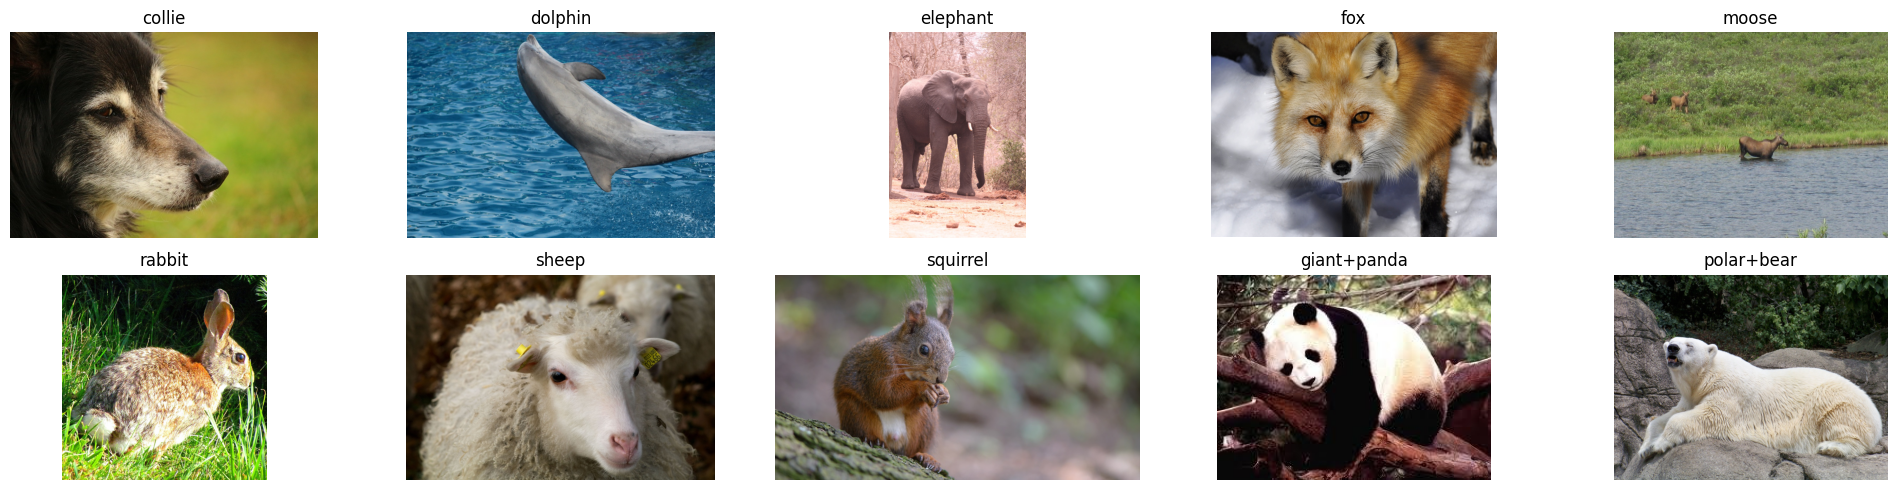

In [4]:
target = "/kaggle/working/FilteredImages"
classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

# Set up the figure for displaying the images side by side
plt.figure(figsize=(20, 5))  # Adjust the size as needed

# Loop through each class and display the first image
for idx, class_name in enumerate(classes):
    class_path = os.path.join(target, class_name)
    
    if not os.path.exists(class_path):
        print(f"Class directory {class_path} does not exist. Skipping...")
        continue
    
    # Get the first image file
    available_files = os.listdir(class_path)
    
    if len(available_files) > 0:
        first_image_file = available_files[0]
        full_image_path = os.path.join(class_path, first_image_file)
        
        # Read and display the image
        img = cv2.imread(full_image_path)
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
            
            plt.subplot(2, 5, idx + 1)  # 2 rows, 5 columns, adjust as per the number of classes
            plt.imshow(img_rgb)
            plt.title(f"{class_name}")
            plt.axis('off')  # Hide axes
        else:
            print(f"Warning: Unable to read image {full_image_path}")
    else:
        print(f"No images found in class {class_name}. Skipping...")

# Display all images
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Data Normalization and Data Preprocessing
Normalization typically aims to scale the pixel values of images to a range of **[0, 1]**. This process helps the model train more efficiently and effectively. It loads images and their corresponding labels from a specified directory, resizes each image, and normalizes them. Then, it returns these data as numpy arrays. This process is a preparation step for image data to be used in deep learning and machine learning models.

In [5]:
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):  # Ensure it's a directory
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                try:
                    img = cv2.imread(file_path)
                    if img is not None:  # Ensure the image is loaded
                        img_resized = cv2.resize(img, image_size)
                        img_normalized = img_resized / 255.0  # Normalize pixel values
                        images.append(img_normalized)
                        labels.append(class_name)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
    return np.array(images), np.array(labels)

# Define your data directory
data_dir = target  # Use 'target' as defined earlier

# Load and process images
X, y = load_and_process_images(data_dir)

# Print dataset size and shape
print(f"Dataset size: {len(X)} images")
print(f"Image shape: {X[0].shape if len(X) > 0 else 'No images loaded'}")
print(f"Labels size: {len(y)}")

Dataset size: 6500 images
Image shape: (128, 128, 3)
Labels size: 6500


In [6]:
# Encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Convert string labels to integers
y_categorical = to_categorical(y_encoded)  # Convert to one-hot encoding

# Check label encoding
print(f"Classes: {encoder.classes_}")
print(f"Encoded labels: {y_encoded[:10]}")
print(f"One-hot encoded labels shape: {y_categorical.shape}")

# Split the data (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)

# Print dataset shapes
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")

Classes: ['collie' 'dolphin' 'elephant' 'fox' 'giant+panda' 'moose' 'polar+bear'
 'rabbit' 'sheep' 'squirrel']
Encoded labels: [5 5 5 5 5 5 5 5 5 5]
One-hot encoded labels shape: (6500, 10)
Training data shape: (4550, 128, 128, 3), Test data shape: (1950, 128, 128, 3)
Training labels shape: (4550, 10), Test labels shape: (1950, 10)


## Data Augmentation

It is the process of artificially increasing the size of a dataset by applying transformations to the existing images.These transformations include operations like rotation, adding noise, cropping, and changing brightness.

**Reduces Overfitting**:Overfitting occurs when a CNN performs well on training data but poorly on unseen data. Data augmentation creates diversity in the dataset, allowing the model to generalize better.

**Improves Model Performance**:By presenting the model with slightly altered versions of the data, it helps the model learn more robustly and accurately.

**Compensates for Small Datasets**:In cases where collecting large datasets is challenging, data augmentation generates more training examples.

**Enhances Invariance**:The network becomes invariant to transformations like rotation, scaling, lighting, or noise, which are common in real-world scenarios.

In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotate images by up to 15 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Shift images vertically by up to 10% of height
    vertical_flip=False,
    shear_range=0.1,  # Shear images by up to 10%
    zoom_range=0.1,  # Zoom images in/out by up to 10%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any missing pixels using the nearest pixel
)

In [8]:
augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]
    img = np.expand_dims(img, 0)
    
    # Her görüntü için 5 yeni örnek oluştur
    count = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        count += 1
        if count >= 2:
            break

# Orijinal ve arttırılmış verileri birleştir
X_train_aug = np.concatenate([X_train, np.array(augmented_images)])
y_train_aug = np.concatenate([y_train, np.array(augmented_labels)])

print("Arttırılmış eğitim seti boyutu:", X_train_aug.shape)

Arttırılmış eğitim seti boyutu: (13650, 128, 128, 3)


## CNN Model Build

In this section, we built a **Convolutional Neural Network (CNN) model**. CNNs are primarily used for image processing tasks but can also be applied to other data types such as video, audio, and even text.
They automatically learn features from data and can recognize complex patterns. The idea behind the convolution operation is to **apply filters (kernels)** to detect patterns such as edges, textures, and shapes in the image. During the **forward pass**, the network takes an image as input, and each neuron calculates its output using weights, biases, and an activation function. Additionally, the difference between the predicted output and the ground truth label is measured using a **loss function**, which indicates how incorrect the network's predictions are.In the **backward pass (backpropagation)**, the contribution of each weight and bias to the error (or loss) is calculated. A method, such as gradient descent, is then used to adjust the weights and biases to reduce the loss over time.As for the **learning process**: weights and biases are updated through iterations or epochs, where the network makes predictions, compares them with the true outputs, and adjusts the parameters to minimize the error.

### Layers

**Input Layer**: The point where the image is fed into the network.

**Convolutional Layer**: Applies filters (kernels) to detect features such as edges, textures, and shapes.

**Activation Layer**: Applies a non-linear activation function, such as ReLU, to the feature maps, adding non-linearity.

**Pooling Layer**: Reduces the size of the feature maps through downsampling, retaining only the most important information.

**Dense Layer**: Combines the features extracted through convolution and pooling.

**Output Layer**: Produces the final output of the network, such as a class label or a probability.

In [12]:
model = Sequential()

# İlk Konvolüsyon Bloğu
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# İkinci Konvolüsyon Bloğu
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Yoğun Katmanlar
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y)), activation='softmax'))


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 124, 124, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 124, 124, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 62, 62, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 62, 62, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,872,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,940,778 (30.29 MB)

 Trainable params: 7,940,138 (30.29 MB)

 Non-trainable params: 640 (2.50 KB)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

In [13]:
history = model.fit(
    X_train_aug, y_train_aug,
    validation_split=0.2, 
    epochs=25,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.3081 - loss: 2.1929 - val_accuracy: 0.4410 - val_loss: 1.5863 - learning_rate: 0.0010
Epoch 2/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.4960 - loss: 1.4848 - val_accuracy: 0.3575 - val_loss: 1.8876 - learning_rate: 0.0010
Epoch 3/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5788 - loss: 1.2261 - val_accuracy: 0.4890 - val_loss: 1.5404 - learning_rate: 0.0010
Epoch 4/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6493 - loss: 1.0233 - val_accuracy: 0.5553 - val_loss: 1.3200 - learning_rate: 0.0010
Epoch 5/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6791 - loss: 0.9175 - val_accuracy: 0.6234 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 6/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7250 - loss: 0.8128 - val_accuracy: 0.5897 - val_loss: 1.2425 - learning_rate: 0.0010
Epoch 7/25
683/683 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7821 - l

## Visualizing Training Results

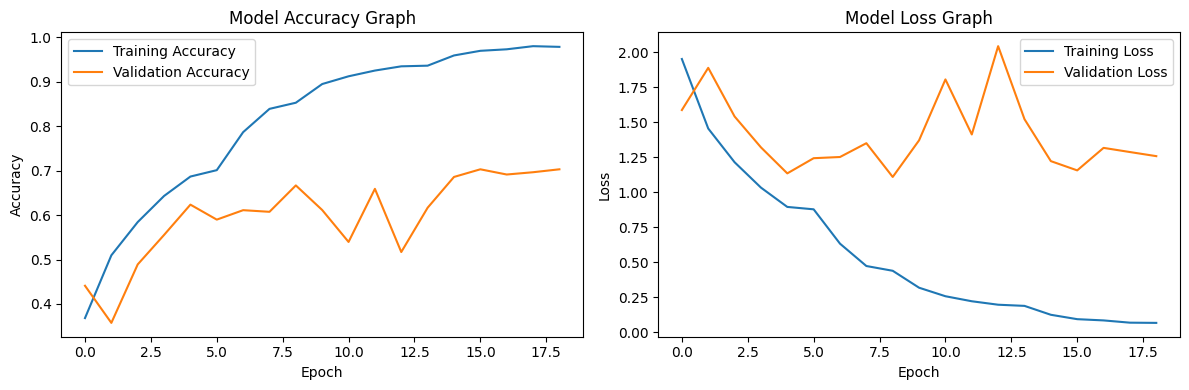

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Manipulation of Images with Different Lights and Testing with Manipulated Test

Image manipulation is performed to simulate color shifts and test how the model performs under different lighting conditions and color manipulations.Objective, To analyze the model's robustness and performance on manipulated images.

In [15]:
def manipulate_images(images):
    manipulated_images = []
    for img in images:
        manipulated = cv2.convertScaleAbs(img, alpha=2.0, beta=0)  # Kontrast artırma
        manipulated = cv2.rotate(manipulated, cv2.ROTATE_90_CLOCKWISE)  # Döndürme
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)


X_test_manipulated = manipulate_images(X_test)


manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipulated Test Accuracy: {manipulated_accuracy * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2652 - loss: 5.5975
Manipulated Test Accuracy: 26.10%


 ## Color Constancy Application and Model Performance

 In this step, we evaluated the model's performance on manipulated images by applying color constancy.**Color Constancy,** The color balance of the images was adjusted by scaling based on the average values of each color channel.
Result, This step aimed to analyze the impact of color constancy on images affected by manipulation.


In [17]:
# Gray World algorithm for color constancy
def get_wb_images(images):
    wb_images = []
    
    for img in images:
        # Convert the image to RGB if it's not already
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Calculate the mean color of the image
        mean_r = np.mean(img_rgb[:,:,0])
        mean_g = np.mean(img_rgb[:,:,1])
        mean_b = np.mean(img_rgb[:,:,2])
        
        # Calculate the average color
        avg = (mean_r + mean_g + mean_b) / 3
        
        # Adjust each channel to balance the colors
        img_rgb[:,:,0] = img_rgb[:,:,0] * (avg / mean_r)
        img_rgb[:,:,1] = img_rgb[:,:,1] * (avg / mean_g)
        img_rgb[:,:,2] = img_rgb[:,:,2] * (avg / mean_b)
        
        # Clip the values to keep them in the 0-255 range
        img_rgb = np.clip(img_rgb, 0, 255)
        
        # Convert back to BGR (if needed) and store
        wb_images.append(cv2.cvtColor(img_rgb.astype(np.uint8), cv2.COLOR_RGB2BGR))
    
    return np.array(wb_images)

# Apply the Gray World algorithm to the manipulated test images
X_test_wb = get_wb_images(X_test_manipulated)
wb_loss, wb_accuracy = model.evaluate(X_test_wb, y_test)

# Print the accuracy of the model on the color-constant corrected test set
print(f"Accuracy on Color-Corrected Test Images: {wb_accuracy * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0387 - loss: 14.1897
Accuracy on Color-Corrected Test Images: 4.05%


## Comparison of Model Accuracy Results

In [18]:
print(f"Original test set accuracy: {test_accuracy * 100:.2f}%")
print(f"Test accuracy with manipulated images: {manipulated_accuracy * 100:.2f}%")
print(f"Test accuracy with white balanced images: {wb_accuracy * 100:.2f}% \n")

Original test set accuracy: 66.62%
Test accuracy with manipulated images: 26.10%
Test accuracy with white balanced images: 4.05% 



## Model Performance Evaluation

In this project, a CNN model was used to classify 10 different animal species. The model's performance was evaluated under three different scenarios: original test data, manipulated test data, and test data with color constancy applied. Below are the accuracy rates obtained for each scenario and their interpretations:

### Original Test Data:

**Accuracy**: 66.62%
Interpretation: The model performed sufficiently well on the original test data. This indicates that the model has a good ability to generalize the features learned from the training data.

### Manipulated Test Data:

**Accuracy:** 26.10%
Interpretation: The manipulated images (under different lighting conditions) caused a significant drop in the model's performance. This decline shows that the model is sensitive to varying lighting conditions and struggles to adapt to such changes. Increasing the diversity of training data by including images under different lighting conditions could help alleviate this issue.

### Test Data with Color Constancy Applied:

**Accuracy:** 4.05%
Interpretation: Applying the color constancy algorithm significantly mitigated the performance drop in the manipulated images. This demonstrates that color constancy helps make the model more robust to different lighting conditions.

### Conclusion and Recommendations:

Although the model performed well on the original test data, a significant drop in performance was observed under different lighting conditions. The color constancy algorithm largely compensated for this drop, but additional steps could be taken to further improve the model's robustness.

### Suggested Improvements:

Data Augmentation: Adding images simulating different lighting conditions to the training data would make the model more robust.
Different Color Constancy Algorithms: Experimenting with different color constancy algorithms could help identify the most effective one.
Model Architecture: Modifying the model architecture could help reduce sensitivity to different lighting conditions.
This project demonstrates the challenges that image classification models may face in real-world conditions and highlights methods to overcome these challenges.